In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from PIL import Image
import skimage
from skimage import measure
%matplotlib inline

c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
path = r"C:\\Users\\narendra\\Documents\\LER\\"

#model = load_model(path + 'models/' + 'EDGEnet_run_epoch_4.h5')

model = load_model(path + 'LER_machine_learning\\models\\' + 'Linenet_image3_round_L2_epoch_2.h5')

In [3]:
sigma = 1.2
alpha = 0.8
Xi = 40
width = 20
space = 40
noise = 2
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 

original_file = path + 'original_images3\\oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images3\\nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'
linescan_file = path + 'linescans\\linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
im = np.array(Image.open(original_file))
im = im/256
imnoisy = np.array(Image.open(noisy_file))
imnoisy = (imnoisy)/256
imnoisy = imnoisy.reshape(1,1024,256,1)

predict = np.zeros([1,1024,256,2])
for k in range(4):
    predict[:,k*256:(k+1)*256, 0:256, :] = model.predict(imnoisy[:,k*256:(k+1)*256, 0:256, :])
    #print(model.predict(imnoisy[:,k*256:(k+1)*256, 0:256, :]).shape)

predict = predict.reshape(1024,256,2)
imnoisy = imnoisy.reshape(1024,256)

8192
PSNR noisy image =  10.235165295455326
PSNR predicted image =  25.81902946150063


Text(0.5,1,'(e) Predicted Edge Image')

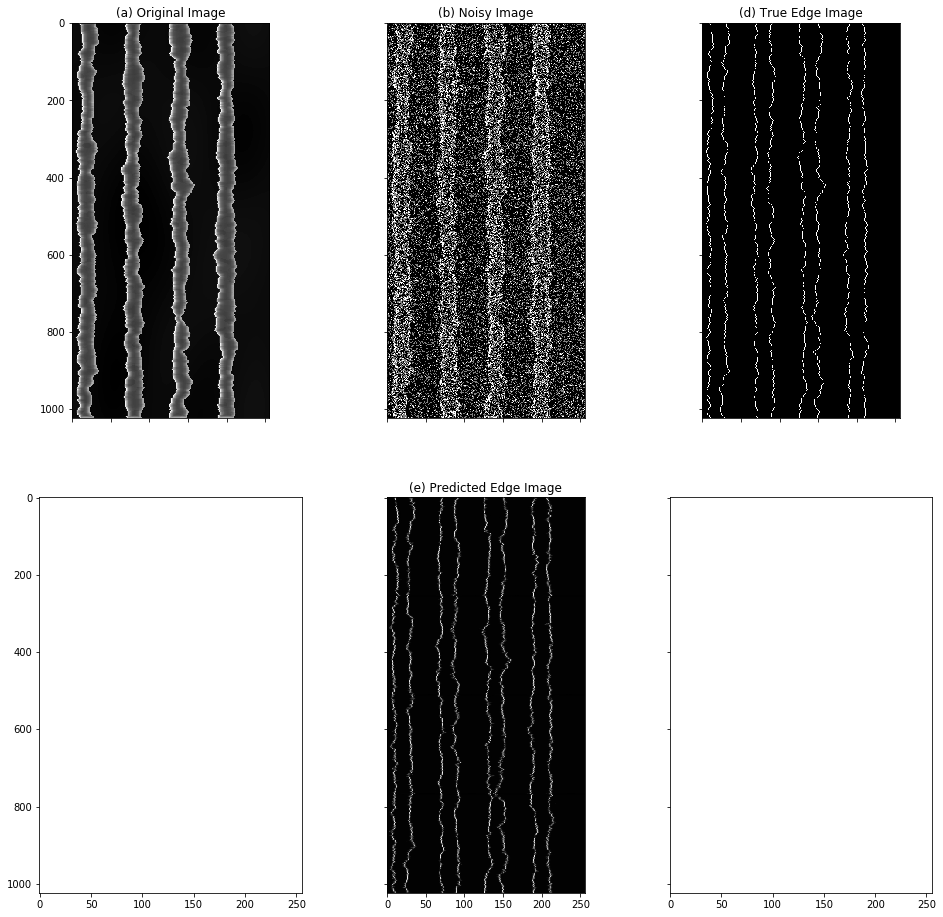

In [4]:
linescan = []
with open(linescan_file,'r') as f:
    for i,line in enumerate(f):
        if i < 8192:
            a, b = line.split(',')
            linescan.append(float(b))
        else:
            break
print(len(linescan))

linescan = np.array(linescan)
linescan = linescan + shift
linescan = linescan.round().astype(int)
edgeimage = np.zeros((1024,256))

if width == 30:                             #number of edges or peaks in a line
    nedges = 6
else:
    nedges = 8


original_edges = np.zeros((nedges, 1024))
for k in range(nedges):                                  #for k edges
    if k%2 == 0:                                    #keep even edges same 
        edge = linescan[k*1024:(k+1)*1024]
    else:
        edge = np.flip(linescan[k*1024:(k+1)*1024],0)  #flip odd edges
    
    original_edges[k,:] = edge
    for i in range(1024):
        if edge[i] >= 0 and edge[i] <= 255:
            edgeimage[i, edge[i]] = 1
            edgeimage[i, edge[i]] = 1

            
psnr_noisy = measure.compare_psnr(im,imnoisy.astype(float))
psnr_predict = measure.compare_psnr(im,predict[:,:,0].astype(float))
print('PSNR noisy image = ', psnr_noisy)
print('PSNR predicted image = ', psnr_predict)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 16), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

ax[0,0].imshow(im,cmap = 'gray',aspect= 0.5)
ax[0,0].set_title('(a) Original Image')

ax[0,1].imshow(imnoisy, cmap = 'gray',aspect= 0.5)
ax[0,1].set_title('(b) Noisy Image')

ax[0,2].imshow(predict[:,:,0], cmap = 'gray',aspect= 0.5)
ax[0,2].set_title('(c) Predicted Denoised Image \n PSNR = {0:.4g}'.format(psnr_predict))

ax[0,2].imshow(edgeimage, cmap = 'gray',aspect= 0.5)
ax[0,2].set_title('(d) True Edge Image')

ax[1,1].imshow(predict[:,:,1], cmap = 'gray',aspect= 0.5)
ax[1,1].set_title('(e) Predicted Edge Image')

#ax[1,0].imshow(np.abs(predict[:,:,1] - edgeimage), cmap = 'gray',aspect= 0.5)
#ax[1,0].set_title('EDGE Difference Image')

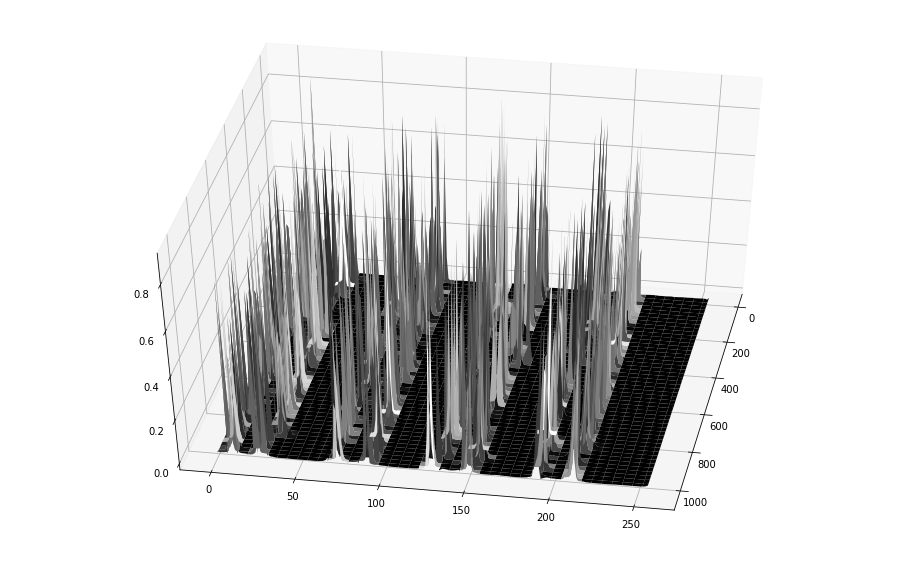

In [5]:
# code for 3d plot and finding peaks

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111,projection='3d')
ax.view_init(elev=45., azim=10)

x, y = np.mgrid[0:1024, 0:256]
surf = Axes3D.plot_surface(ax, x, y, predict[:,:,1], cmap=cm.gray)
plt.show()

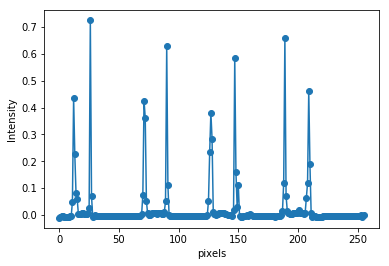

In [6]:
from scipy.signal import find_peaks    # To get maxima

N = 256
#print(find_peaks(predict[N,:,1], height = 0.1, distance = 3))
plt.plot(predict[N,:,1], '-o')                         # plot one row of edge image
plt.xlabel('pixels')
plt.ylabel('Intensity')
plt.show()

In [7]:

predicted_edges = np.zeros((nedges, 1024))
mean_edge_pos = np.zeros(8)
dist = 10         # initial minimum distance between the peaks
over = 0          # flag peak finishing peak search

while(not over):
    mean_edge_pos = np.zeros(8)
    for i in range(1024):
        peaks, _ = find_peaks(predict[i,:,1], height = 0.11, distance = dist)
    
        mean_edge_pos = predicted_edges[:,:i].mean(axis=1)       # mean edge position
        if len(peaks) < nedges:
            dist = dist - 1
            break
        elif len(peaks) == nedges or i == 0:
            for k in range(nedges):
                predicted_edges[k,i] = peaks[k]
        else:
            for k in range(nedges):
                min_index = np.argmin(np.abs(peaks - mean_edge_pos[k]))
                predicted_edges[k,i] = peaks[min_index]
        if i == 1023:
            print (dist)
            over = 1

c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: Mean of empty slice.
c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


4


[1.02194723 1.24182114 1.01537707 1.2345101  1.30266693 1.46879026
 1.17660342 0.85521663]
[1.06214405 1.26725005 1.01025273 1.2498165  1.31542498 1.54429704
 1.14271959 0.87177664]
LER:  1.1646165968305149 1.1829601977522766
MABSE: 0.44970703125
LWR:  1.5071549740947094 1.5564655036341197
PSNR:  10.235165295455326 25.81902946150063


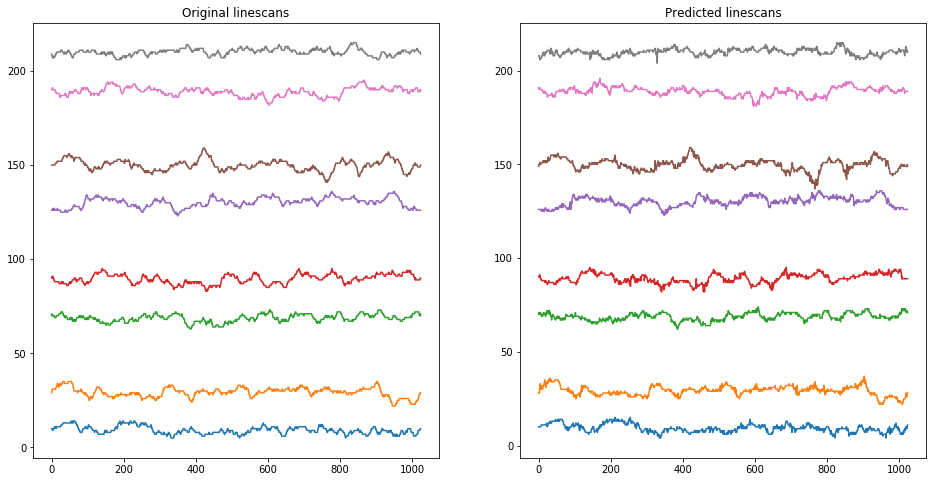

In [8]:
print(original_edges.std(axis = 1)/2)
print(predicted_edges.std(axis = 1)/2)


print("LER: ",(original_edges.std(axis = 1)/2).mean(), (predicted_edges.std(axis = 1)/2).mean())


print("MABSE:", np.abs(original_edges - predicted_edges).sum(axis=1).sum()/(nedges*1024))

original_LWR = np.zeros(nedges//2)
predicted_LWR = np.zeros(nedges//2)

for i in range(nedges//2):
    original_LWR[i] = (original_edges[i+1,:] - original_edges[i,:]).std()/2
    predicted_LWR[i] = (predicted_edges[i+1,:] - predicted_edges[i,:]).std()/2

print("LWR: ", original_LWR.mean(), predicted_LWR.mean())
print("PSNR: ", psnr_noisy, psnr_predict)
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharex=True,
                       sharey=False, subplot_kw={'adjustable': 'box-forced'})

ax[0].plot(original_edges.T)
ax[0].set_title('Original linescans')

ax[1].plot(predicted_edges.T)
ax[1].set_title('Predicted linescans')

plt.show()